<a href="https://colab.research.google.com/github/rahiakela/nlp-research-and-practice/blob/main/getting-started-with-nlp/09-topic-analysis/topic_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Topic Analysis

In this notebook, you will work with one more application of
this powerful framework – topic classification.

Let’s start with a scenario: suppose you work
as a content manager for a large news platform. Your platform hosts texts from a wide
variety of authors and mainly specializes in the following set of well-established topics:
“Politics”, “Finance”, “Science”, “Sports”, and “Arts”. Your task is to decide, for every
incoming article, which topic it belongs to and post it under the relevant tab on the platform.

This scenario relates to the task that we can broadly define as topic analysis.

Imagine
that the content on your platform doesn’t stay the same all the time – new topics may
emerge in the data.

Unfortunately, if you wanted to train a classification model to cover
these topics in a supervised manner, you will need labeled articles for these new topics as
well.

Data availability is the major bottleneck for supervised machine learning.

Therefore, you need to learn about alternative ways of topic discovery and need to apply two unsupervised machine learning algorithms –

* Clustering
* Latent Dirichlet Allocation


<img src='https://github.com/rahiakela/natural-language-processing-research-and-practice/blob/main/getting-started-with-nlp/09-topic-analysis/images/1.png?raw=1' width='600'/>

##Setup

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.datasets import fetch_20newsgroups

import random
import numpy as np
import matplotlib.pyplot as plt

##Dataset

In [3]:
def load_dataset(subsets, cats):
  dataset = fetch_20newsgroups(subset=subsets, categories=cats, remove=("headers", "footers", "quotes"), shuffle=True)
  return dataset

In [4]:
categories = ["comp.windows.x", "misc.forsale", "rec.autos", "rec.motorcycles", "rec.sport.baseball"]
categories += ["rec.sport.hockey", "sci.crypt", "sci.med", "sci.space", "talk.politics.mideast"]

newsgroups_train = load_dataset("train", categories)
newsgroups_test = load_dataset("test", categories)

In [5]:
# Let's check our uploaded data subsets
def check_data(dataset):
  print(list(dataset.target_names))
  print(dataset.filenames.shape)
  print(dataset.target.shape)

  if dataset.filenames.shape[0] == dataset.target.shape[0]:
    print("Equal sizes for data and targets")

  print(dataset.filenames[0])
  print(dataset.data[0])
  print(dataset.target[:10])

In [6]:
check_data(newsgroups_train)
print("\n***\n")
check_data(newsgroups_test)

['comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'talk.politics.mideast']
(5913,)
(5913,)
Equal sizes for data and targets
/root/scikit_learn_data/20news_home/20news-bydate-train/rec.sport.baseball/102665
I have posted the logos of the NL East teams to alt.binaries.pictures.misc 
 Hopefully, I'll finish the series up next week with the NL West.

 Darren

[4 3 9 7 4 3 0 5 7 8]

***

['comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'sci.space', 'talk.politics.mideast']
(3937,)
(3937,)
Equal sizes for data and targets
/root/scikit_learn_data/20news_home/20news-bydate-test/misc.forsale/76785
As the title says. I would like to sell my Star LV2010 9 pin printer.
Its a narrow colum dot matrix, supports both parallel and serial
interfacing, prints at 200 characters per second, has a 16K buffer, 
and is very dependab

##Naïve Bayes classifier

Topic classification
task on the basis of word occurrences boils down to recognizing which topic a text may
belong to based on which words are used in this text.

TF-IDF is a technique that allows you to downweigh terms
that occur frequently across many documents and upvalue terms that occur frequently only
in some documents but not across the whole collection.

In [7]:
# apply TfidfVectorizer and convert texts into vectors
def text2vec(vectorizer, train_set, test_set):
  # estimates tf-idf weights on the training data and then applies them to the test data
  vectors_train = vectorizer.fit_transform(train_set.data)
  vectors_test = vectorizer.transform(test_set.data)
  return vectors_train, vectors_test

In [8]:
vectorizer = TfidfVectorizer(stop_words="english")

vectors_train, vectors_test = text2vec(vectorizer, newsgroups_train, newsgroups_test)

print(vectors_train.shape)
print(vectors_test.shape)
print(vectors_train[0])
print(vectorizer.get_feature_names_out()[33404])

(5913, 52746)
(3937, 52746)
  (0, 36985)	0.1806134526365663
  (0, 29330)	0.32348469409130415
  (0, 33404)	0.47274197987346267
  (0, 17820)	0.1996672692556469
  (0, 46098)	0.18751137951875305
  (0, 6736)	0.23045715683316248
  (0, 9616)	0.2606508810838842
  (0, 36274)	0.23637098993673133
  (0, 31546)	0.21952696479551445
  (0, 24214)	0.23045715683316248
  (0, 29215)	0.14244326085583361
  (0, 20349)	0.2372918776268056
  (0, 42031)	0.1891577831889085
  (0, 50435)	0.1817612919269656
  (0, 50534)	0.20153071455804605
  (0, 15218)	0.31618146678372416
nl


In [9]:
print(vectorizer.get_feature_names_out()[15218])

darren


In [10]:
print(vectorizer.get_feature_names_out()[50534])

west


In [11]:
# perform topic classification with the Naïve Bayes classifier
clf = MultinomialNB(alpha=0.1)  # Initialize the algorithm. Alpha parameter controls smoothing
clf.fit(vectors_train, newsgroups_train.target)
predictions = clf.predict(vectors_test)

In [14]:
# evaluate the results for this approach
def show_top(classifier, categories, vectorizer, n):
  feature_names = np.asarray(vectorizer.get_feature_names_out())
  for i, category in enumerate(categories):
    # returns a list of probabilities for the features and sorts this list in the increasing order
    top = np.argsort(classifier.feature_log_prob_[i])[-n:]
    print(f"{category}-{' '.join(feature_names[top])}")

In [15]:
# print out the full classification_report as well as the top 10 informative features per category
full_report = metrics.classification_report(newsgroups_test.target,
                                            predictions,
                                            target_names=newsgroups_test.target_names)
print(full_report)
show_top(clf, categories, vectorizer, 10)

                       precision    recall  f1-score   support

       comp.windows.x       0.92      0.90      0.91       395
         misc.forsale       0.88      0.87      0.87       390
            rec.autos       0.83      0.78      0.80       396
      rec.motorcycles       0.85      0.80      0.83       398
   rec.sport.baseball       0.92      0.84      0.88       397
     rec.sport.hockey       0.71      0.94      0.81       399
            sci.crypt       0.82      0.85      0.83       396
              sci.med       0.92      0.82      0.87       396
            sci.space       0.86      0.82      0.84       394
talk.politics.mideast       0.86      0.90      0.88       376

             accuracy                           0.85      3937
            macro avg       0.86      0.85      0.85      3937
         weighted avg       0.86      0.85      0.85      3937

comp.windows.x-program using application windows widget use thanks motif server window
misc.forsale-asking email se

[[355   8   2   2   1   8  12   2   5   0]
 [  3 339  16   9   4  11   2   1   5   0]
 [  0   9 308  25   3  27   7   3   9   5]
 [  2   8  26 320   4  15   9   4   6   4]
 [  3   7   0   2 333  33   4   5   2   8]
 [  1   0   0   2   6 374   8   2   2   4]
 [  9   7   3   3   2  18 335   2   7  10]
 [  2   4   9   5   3  17   7 324  13  12]
 [  9   3   7   2   3  18  11   6 324  11]
 [  2   0   2   7   2   9  13   2   2 337]]


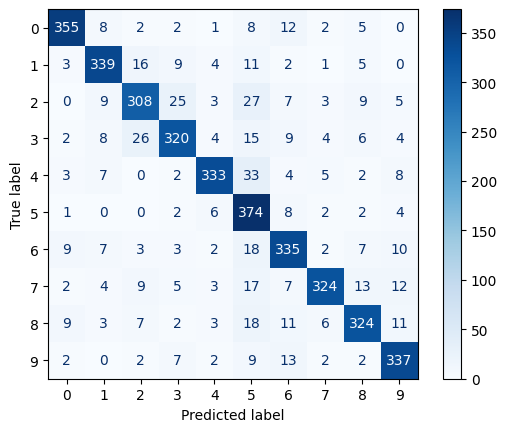

0 comp.windows.x
1 misc.forsale
2 rec.autos
3 rec.motorcycles
4 rec.sport.baseball
5 rec.sport.hockey
6 sci.crypt
7 sci.med
8 sci.space
9 talk.politics.mideast


In [16]:
# explore the classifier’s errors and confusions
classifier = clf.fit(vectors_train, newsgroups_train.target)

disp = ConfusionMatrixDisplay.from_estimator(classifier,
                             vectors_test,
                             newsgroups_test.target,
                             values_format="0.0f",
                             cmap=plt.cm.Blues)
print(disp.confusion_matrix)
plt.show()

for i, category in enumerate(newsgroups_train.target_names):
  print(i, category)

##Data preparation for unsupervised approach

By using unsupervised algorithm, we will try to identify such
representative object with the averaged values for the features across the group, and cluster
other objects from the same group around this central point.

Such representative object is
technically called centroid, and this particular unsupervised approach is called clustering.

How do you actually calculate the distance between the points?

Euclidean distance  calculate the sum of squared differences between
the relevant coordinates of the points, and then take the square root of this sum.

In [ ]:
# prepare the data for clustering
random.seed(42)

# Since clustering is an unsupervised technique, we don’t have to separate the data into two sets, so let’s combine them together in one set
all_news = list(zip(newsgroups_train.data, newsgroups_train.target))
all_news += list(zip(newsgroups_test.data, newsgroups_test.target))
random.shuffle(all_news)

# Store the contents and labels separately
all_news_data = [text for (text, label) in all_news]
all_news_labels = [label for (text, label) in all_news]

print("Data:")
print(f"{str(len(all_news_data))} posts in  {str(np.unique(all_news_labels).shape[0])} categories\n")

print("Labels:")
print(all_news_labels[:10])
num_clusters = np.unique(all_news_labels).shape[0]
print(f"Assumed number of clusters: {str(num_clusters)}")

Data:
9850 posts in  10 categories

Labels:
[2, 6, 1, 9, 0, 5, 1, 2, 9, 0]
Assumed number of clusters: 10


So now, we will approach the task in an unsupervised manner: our algorithm will be working with the `9,850` posts in `all_news_data`, and it will not get access to the labels contained in `all_news_labels`, although you can use them at the very last, evaluation, step.

##Singular Value Decomposition

The goal of the SVD algorithm is to significantly reduce data dimensionality to help
expensive algorithms like clustering deal with it more efficiently, while keeping as much of
the valuable information in the reduced data as possible.

That is, when SVD reduces the data
from over 30,000 columns to 300 (thus keeping essentially about 1%), it doesn’t just throw
away the other 99% of the data. Instead, it tries to “distil” and “summarize” the information
contained in the original huge matrix down to a much smaller number of dimensions.

In general, SVD tries to simplify a big matrix representation by decomposing it into 3
smaller ones in such a way that when you multiply these 3 smaller matrices you get back the
original one.

You can think of this as somewhat similar to “decomposing” a number like 24
into 4, 3, and 2, as when you multiply these numbers you get the original number back: i.e.,
4*3*2 = 24.

<img src='https://github.com/rahiakela/natural-language-processing-research-and-practice/blob/main/getting-started-with-nlp/09-topic-analysis/images/3.png?raw=1' width='600'/>

You start with a matrix of 9,850 rows (representing posts) and 33,976 columns
(representing words occurring in these posts, that you would like to use as features) – that is
what the original matrix on the left contains in its m-by-n dimensions (in this case, `9,850-by-33,976`).

This is exactly what SVD is trying to achieve: the matrix of m rows by k columns (where the notation `k<<n` means that k is considerably smaller than the original n, as for instance `300<<33,976`) represents the original m (9,850) posts using k (300) concepts, which are also often called latent factors – in other words, factors that are hidden from the naked eye.

<img src='https://github.com/rahiakela/natural-language-processing-research-and-practice/blob/main/getting-started-with-nlp/09-topic-analysis/images/4.png?raw=1' width='600'/>

The second matrix, `k-by-k (300-by-300)`, encodes how such latent factors correspond to
each other; finally, the third one, `k-by-n (300-by-33,976)`, tells you how to interpret the
relations between the latent factors (or concepts) and the original n words.

The beauty of the
algorithm is that you can always get back the original m-by-n matrix by multiplying the 3
smaller matrices, and you don’t need to estimate these constituent matrices yourself – the
algorithm does it for you.

What are these k latent factors then and how to select them?

These factors are the most
prominent (i.e., salient) concepts that the algorithm finds in the data, ordered by their
importance starting with the most prominent one.





Since the original dimensionality of the data is prohibitively large to allow for efficient clustering,

let's reduce its dimensionality using `Singular Value Decomposition`:

In [ ]:
vectorizer = TfidfVectorizer(min_df=2, max_df=0.5, stop_words="english", use_idf=True)

def transform(data, vectorizer, dimensions):
  transformed_data = vectorizer.fit_transform(data)
  print(f"Transformed data contains: {str(transformed_data.shape[0])} with {str(transformed_data.shape[1])} features.")

  svd = TruncatedSVD(dimensions)
  pipeline = make_pipeline(svd, Normalizer(copy=False))
  reduced_data = pipeline.fit_transform(transformed_data)

  return reduced_data, svd

In [ ]:
reduced_data, svd = transform(all_news_data, vectorizer, 300)
print(f"Reduced data contains: {str(reduced_data.shape[0])} with {str(reduced_data.shape[1])} features.")

Transformed data contains: 9850 with 33976 features.
Reduced data contains: 9850 with 300 features.


Now that the data is ready, let’s apply clustering algorithm.

In [ ]:
# run the KMeans clustering algorithm
def cluster(data, num_clusters):
  km = KMeans(n_clusters=num_clusters, init="k-means++", max_iter=100, random_state=0)
  km.fit(data)
  return km

In [ ]:
km = cluster(reduced_data, num_clusters)

Note that here you use an
insight about the number of clusters you are looking for: you try to cluster the posts into 10
clusters because you assume, based on the input data, that there are roughly 10 topics here.

##Evaluation of the topic clustering algorithm

Clustering algorithms can be evaluated using homogeneity (an alternative for
precision in the unsupervised ML setting), completeness (alternative to recall), and vmeasure
(alternative to F-score).

In addition, the informative words that helped the
clustering algorithm identify each cluster’s centroid can be extracted and analyzed.
Based on these words, you can interpret the results: for instance, reason about the
clusters identified in the data and how they correspond to the labeled topics.

Let’s see what results you get for the clustering algorithm.

In [ ]:
# evaluate the results obtained with the clustering algorithm
def evaluate(km, labels, svd):
  print("Clustering report:\n")
  print(f"* Homogeneity: {str(metrics.homogeneity_score(labels, km.labels_))}")
  print(f"* Completeness: {str(metrics.completeness_score(labels, km.labels_))}")
  print(f"* V-measure: {str(metrics.v_measure_score(labels, km.labels_))}")

  print("\nMost discriminative words per cluster:")
  # Get back the centroids
  original_space_centroids = svd.inverse_transform(km.cluster_centers_)
  # Sort them and return the matrix containing the list of most informative dimensions for the cluster centroids
  order_centroids = original_space_centroids.argsort()[:, ::-1]

  terms = vectorizer.get_feature_names()
  for i in range(num_clusters):
    print(f"Cluster {str(i)} : ")
    cl_terms = ""
    for idx in order_centroids[i, :50]:
      cl_terms += terms[idx] + " "
    # Map them back to words
    print(cl_terms + "\n")

In [ ]:
evaluate(km, all_news_labels, svd)

print("\nCategories:")
for i, category in enumerate(newsgroups_train.target_names):
  print("*", category)

Clustering report:

* Homogeneity: 0.5055255205654755
* Completeness: 0.6056584837503299
* V-measure: 0.5510803234992664

Most discriminative words per cluster:
Cluster 0 : 
just like don know think does people thanks good edu right time new say ve com did make use mail sure got ll really way want actually list let used better need going read problem years thought probably question tell looking heard article post little doesn things cars stuff didn 

Cluster 1 : 
doctor disease medical msg patients know pain don cause cancer treatment food like people patient gordon body drug yeast candida good geb skepticism time effects pitt banks n3jxp dsl medicine cadre chastity diet intellect health ve shameful surrender just does edu effect help blood soon chronic think years problem infection 

Cluster 2 : 
space orbit launch nasa shuttle moon earth mission lunar solar satellite like hst spacecraft just cost think program time station know data use long don mars low years idea sky science satell

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
